In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import numpy as np

In [2]:
alexnet = models.vgg16(pretrained=True)
alexnet.cuda()
# this is important. turn off dropout.
_ = alexnet.eval()

In [3]:
from torchvis import util

In [4]:
vis_param_dict, reset_state, remove_handles = util.augment_module(alexnet)

In [5]:
# ok. let's put in some images, and see what happens.
# let's just load some image
# this is the same image as in <https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb>

In [6]:
from PIL import Image # so, this woorks better than skimage, as torchvision transforms work best with PIL and Tensor.
from torchvision import transforms

In [7]:
img_to_use = Image.open('./4334173592_145856d89b.jpg')
print(img_to_use.size)

(500, 355)


In [8]:
transform_1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ]),
])

img_to_use_cropped = transform_1(img_to_use)
img_to_use_cropped_tensor = transform_2(img_to_use_cropped)[np.newaxis]  # add first column for batching

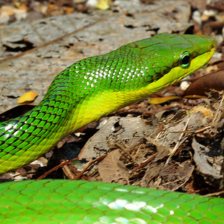

In [9]:
img_to_use_cropped  # this is same as Lasagne example.

In [10]:
input_img = Parameter(img_to_use_cropped_tensor.cuda(), requires_grad=True)
if input_img.grad is not None:
    input_img.grad.data.zero_()
alexnet.zero_grad()
# wrap input in Parameter, so that gradients will be computed.
raw_score = alexnet(input_img)
raw_score_numpy = raw_score.data.cpu().numpy()
print(raw_score_numpy.shape, np.argmax(raw_score_numpy.ravel()))
loss = raw_score.sum()
print('loss', loss)
# second time, there's no output anymore, due to lack of hook
# I didn't call it, as maybe zero_grad may have some interaction with it. Not sure. Just for safety.
# _ = alexnet(Variable(img_to_use_cropped_tensor.cuda()))

features.1 torch.Size([1, 64, 224, 224])
features.3 torch.Size([1, 64, 224, 224])
features.6 torch.Size([1, 128, 112, 112])
features.8 torch.Size([1, 128, 112, 112])
features.11 torch.Size([1, 256, 56, 56])
features.13 torch.Size([1, 256, 56, 56])
features.15 torch.Size([1, 256, 56, 56])
features.18 torch.Size([1, 512, 28, 28])
features.20 torch.Size([1, 512, 28, 28])
features.22 torch.Size([1, 512, 28, 28])
features.25 torch.Size([1, 512, 14, 14])
features.27 torch.Size([1, 512, 14, 14])
features.29 torch.Size([1, 512, 14, 14])
classifier.1 torch.Size([1, 4096])
classifier.4 torch.Size([1, 4096])
(1, 1000) 55
loss Variable containing:
 0.5609
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [11]:
# so, forward one time, and backward multiple times.
vis_param_dict['layer'] = 'classifier.6'
vis_param_dict['method'] = util.GradType.NAIVE
# which one coresponds
# this is the max one. I assume it's the correct one.
# indeed, it's correct.
# 55 is n01729977, corresponding to "green snake, grass snake".
vis_param_dict['index'] = 55
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
loss.backward(retain_variables=True)

change grad!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!


In [12]:
# adapted from <https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb>
def show_images(img_original, saliency, title):
    # convert from c01 to 01c
    saliency = saliency.transpose(1, 2, 0)
    
    # put back std fixing.
    saliency = saliency * np.array([ 0.229, 0.224, 0.225 ])
    
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.asarray(img_original))
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.suptitle(title)
    plt.show()

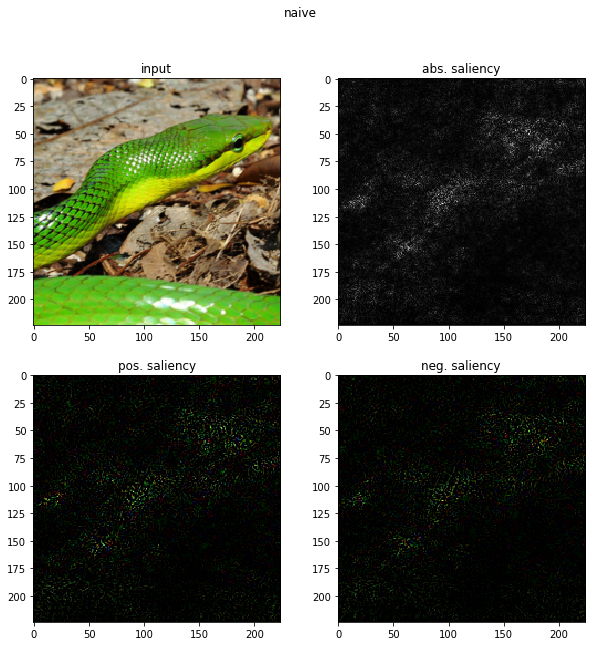

In [13]:
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'naive')

change grad!


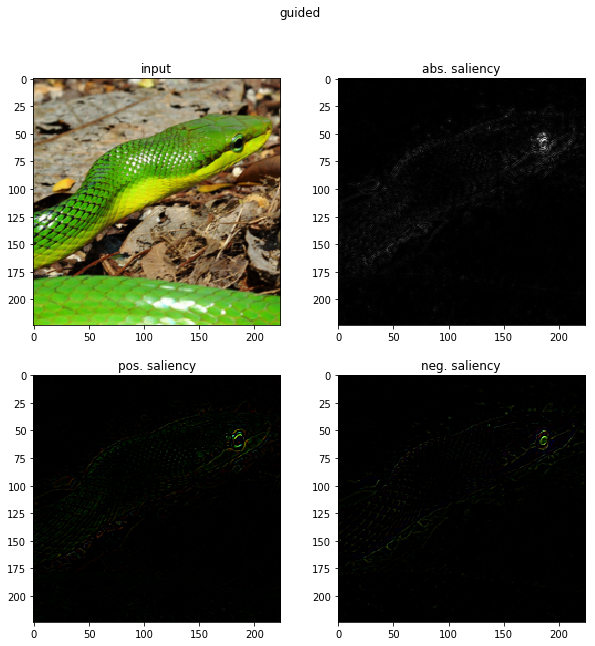

In [14]:
# so, forward one time, and backward multiple times.
vis_param_dict['method'] = util.GradType.GUIDED
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
if input_img.grad is not None:
    input_img.grad.data.zero_()
alexnet.zero_grad()
loss.backward(retain_variables=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'guided')

change grad!


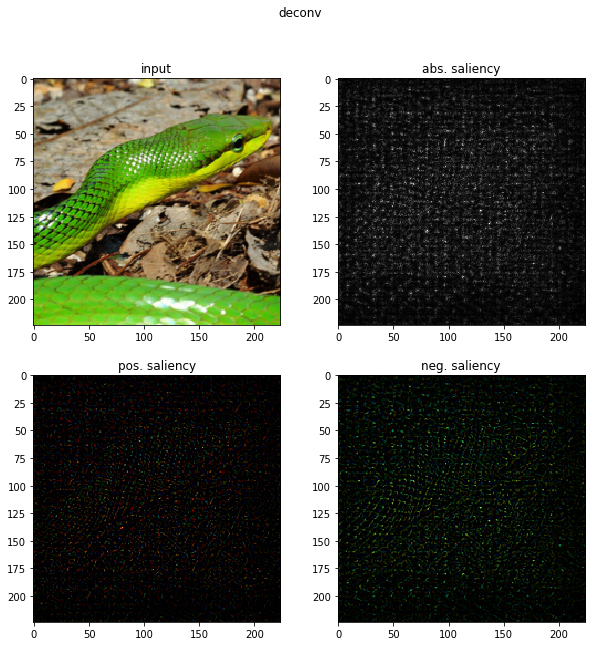

In [15]:
# so, forward one time, and backward multiple times.
vis_param_dict['method'] = util.GradType.DECONV
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
if input_img.grad is not None:
    input_img.grad.data.zero_()
alexnet.zero_grad()
loss.backward(retain_variables=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'deconv')

In [16]:
# reset state
reset_state()

clearing features.1
clearing features.3
clearing features.6
clearing features.8
clearing features.11
clearing features.13
clearing features.15
clearing features.18
clearing features.20
clearing features.22
clearing features.25
clearing features.27
clearing features.29
clearing classifier.1
clearing classifier.4


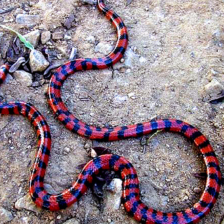

In [17]:
img_to_use = Image.open('./5595774449_b3f85b36ec.jpg')
img_to_use_cropped = transform_1(img_to_use)
img_to_use_cropped_tensor = transform_2(img_to_use_cropped)[np.newaxis]  # add first column for batching
img_to_use_cropped

In [18]:
input_img = Parameter(img_to_use_cropped_tensor.cuda(), requires_grad=True)
if input_img.grad is not None:
    input_img.grad.data.zero_()
alexnet.zero_grad()
# wrap input in Parameter, so that gradients will be computed.
raw_score = alexnet(input_img)
raw_score_numpy = raw_score.data.cpu().numpy()
print(raw_score_numpy.shape, np.argmax(raw_score_numpy.ravel()))
loss = raw_score.sum()
print('loss', loss)

features.1 torch.Size([1, 64, 224, 224])
features.3 torch.Size([1, 64, 224, 224])
features.6 torch.Size([1, 128, 112, 112])
features.8 torch.Size([1, 128, 112, 112])
features.11 torch.Size([1, 256, 56, 56])
features.13 torch.Size([1, 256, 56, 56])
features.15 torch.Size([1, 256, 56, 56])
features.18 torch.Size([1, 512, 28, 28])
features.20 torch.Size([1, 512, 28, 28])
features.22 torch.Size([1, 512, 28, 28])
features.25 torch.Size([1, 512, 14, 14])
features.27 torch.Size([1, 512, 14, 14])
features.29 torch.Size([1, 512, 14, 14])
classifier.1 torch.Size([1, 4096])
classifier.4 torch.Size([1, 4096])
(1, 1000) 56
loss Variable containing:
-3.3215
[torch.cuda.FloatTensor of size 1 (GPU 0)]



change grad!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!
check grad debug!


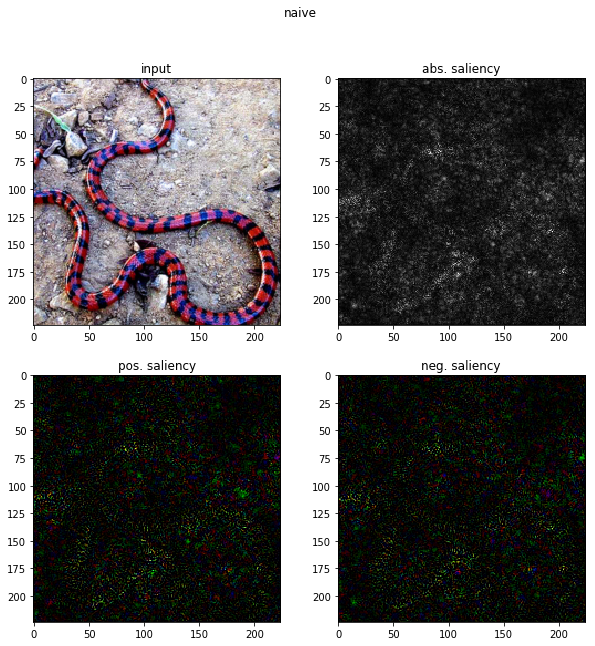

In [19]:
# so, forward one time, and backward multiple times.
vis_param_dict['layer'] = 'classifier.6'
vis_param_dict['method'] = util.GradType.NAIVE
vis_param_dict['index'] = 56
loss.backward(retain_variables=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'naive')

change grad!


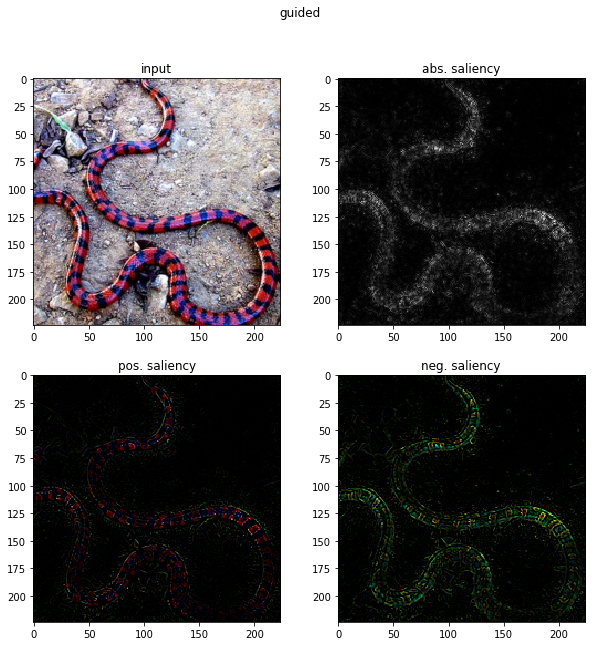

In [20]:
# so, forward one time, and backward multiple times.
vis_param_dict['method'] = util.GradType.GUIDED
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
if input_img.grad is not None:
    input_img.grad.data.zero_()
alexnet.zero_grad()
loss.backward(retain_variables=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'guided')

In [21]:
# then remove all callback
reset_state()
remove_handles()

clearing features.1
clearing features.3
clearing features.6
clearing features.8
clearing features.11
clearing features.13
clearing features.15
clearing features.18
clearing features.20
clearing features.22
clearing features.25
clearing features.27
clearing features.29
clearing classifier.1
clearing classifier.4
